# Задача 1:  Предсказание даты следующего заказа

# I. Импорт библиотек

In [71]:
# !pip install catboost

In [2]:
# !pip install lightgbm

In [35]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import metrics  # подгружаем метрики
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# II. Функции

In [246]:
def process_task_1(df_family):
    '''Приготавливаем данные выбранной семьи для обучения'''
    data = df_family
    data = data.sort_values(by='order_date', ascending=True)
    
    ########################## Creating Timeframe #################################
    # Данные по заказам, которые нужно суммировать
    data_o = data[['order_date','ordered']]
    data_o.columns = ['date','order']
    data_o = data_o.sort_values(by='date', ascending=True)
    data_o = data_o.groupby(['date']).sum()
    data_od = data_o.resample('d').sum()

    # Данные, которые нужно усреднить
    data_l = data.copy()
    data_l = data_l[['order_date', 'leadtime']]
    data_l.columns = ['date','leadtime']
    data_l = data_l.sort_values(by='date', ascending=True)
    data_l = data_l.groupby(['date']).mean()
    data_ld = data_l.resample('d').mean()
    
    # Соединяем
    data_day = pd.concat([data_od, data_ld], axis=1)
    data_day.fillna(0, inplace=True)
    data_day.columns = ['ordered_family','leadtime_family']
    data_day = data_day[data_day.ordered_family > 0]
    
    ######################## Feature Enginnering #################################
    data_day['date'] = data_day.index
    data_day['year'] = data_day['date'].dt.year
    data_day['weekday'] = data_day['date'].dt.weekday
    data_day = data_day.reset_index(drop=True)
    data_day['quarter'] = data_day.date.dt.to_period('Q')
    data_day['month'] = data_day.date.dt.to_period('M')
    data_day['order_diff'] = data_day.ordered_family.diff()
    quarter = data_day.groupby(['quarter']).mean()
    quarter = quarter[['ordered_family']]
    quarter = quarter.reset_index()
    quarter.columns = ['quarter','ordered_mean']
    data_day = pd.merge(data_day, quarter, how='left', on='quarter')
    data_day['volume_inc'] = data_day.ordered_family - data_day.ordered_mean
    data_day['volume_compare'] = data_day.volume_inc.apply(lambda x: 1 if x <= 0 else 0)
    
    ########################## Target Variable ###################################
    data_day['difference'] = data_day.date.diff(-1)
    data_day['difference'] = data_day['difference'].astype('timedelta64[D]')
    data_day['difference'] = data_day['difference'].apply(lambda x: -x)
    
    ########################### Converting to Numeric Format #####################
    data_day['date'] = data_day['date'].astype(int) // 10**9
    data_day['quarter'] = data_day.quarter.astype(int)
    data_day['month'] = data_day.month.astype(int)

    data_day.dropna(inplace=True)
    return data_day

In [247]:
def features_split(data):
    split_coef = 0.8
    
    feature_train, features_test = np.split(data, [int(split_coef*len(data))])
    features_train, features_val = np.split(feature_train, [int(split_coef*len(feature_train))])
    
    return features_train, features_val, features_test

In [248]:
def train_split(features_train, features_val, features_test):
    
    x_train = features_train[features_list]
    x_val = features_val[features_list]
    x_test  = features_test[features_list]
    y_train = features_train['difference']
    y_val = features_val['difference']
    y_test = features_test['difference']
    
    return x_train, x_val, x_test, y_train, y_val, y_test

# III. Данные

In [249]:
df_village = pd.read_csv('village_table.csv')

In [250]:
# Преобразуем в формат datetime
df_village.order_date = pd.to_datetime(df_village.order_date)
df_village.delivery_date = pd.to_datetime(df_village.delivery_date)
# Преобразуем в цифровой формат 
df_village['leadtime'] = df_village['leadtime'].apply(lambda x: x[:-5])
df_village['leadtime'] = df_village['leadtime'].astype(int)

In [251]:
df_village.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243743 entries, 0 to 243742
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   village        243743 non-null  object        
 1   year           243743 non-null  int64         
 2   family         243743 non-null  object        
 3   category       243743 non-null  object        
 4   fruit          243743 non-null  object        
 5   grade          243743 non-null  int64         
 6   order_date     243743 non-null  datetime64[ns]
 7   delivery_date  243743 non-null  datetime64[ns]
 8   ordered        243743 non-null  float64       
 9   shipped        243743 non-null  float64       
 10  leadtime       243743 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 20.5+ MB


In [252]:
df_village.head()

,village,year,family,category,fruit,grade,order_date,delivery_date,ordered,shipped,leadtime
0,Robinhood_village,2020,family_244,category_25,fruit_37,165,2019-12-30,2020-01-03,1650.0,1663.20,4
1,Robinhood_village,2020,family_127,category_14,fruit_62,250,2019-12-30,2020-01-10,1000.0,1060.00,11
2,Robinhood_village,2020,family_133,category_16,fruit_48,330,2019-12-30,2020-01-08,1320.0,1336.50,9
3,Robinhood_village,2020,family_133,category_25,fruit_49,250,2019-12-30,2020-01-08,2500.0,2508.75,9
4,Robinhood_village,2020,family_133,category_4,fruit_52,315,2019-12-30,2020-01-08,4725.0,4759.65,9


In [253]:
#  Создадим датафреймы для каждой семьи
for parent in df_village.family.unique():
    globals()[f'{parent}'] = df_village.query(f"family == '{parent}'")
#     globals()[f'{parent}'].to_csv(f'dfs/{parent}.csv', index=False)

# IV Решение задачи предсказания


## 1. Преобразования данных

In [254]:
# features_list = ['ordered_family','order_diff','leadtime_family','date','year','weekday','quarter', 'month']

In [269]:
features_list = ['ordered_family', 'leadtime_family', 'date', 'year', 'weekday',
       'quarter', 'month',  'order_diff', 'ordered_mean',
       'volume_inc', 'volume_compare']

## 2. Baseline

Baseline - это предсказание дня следующей закупки на основании среднего значения в обучающей выборке

In [256]:
family_119.head()

,village,year,family,category,fruit,grade,order_date,delivery_date,ordered,shipped,leadtime
514,Robinhood_village,2020,family_119,category_3,fruit_310,250,2020-01-03,2020-01-13,4000.0,4000.0,10
551,Robinhood_village,2020,family_119,category_3,fruit_310,400,2020-01-03,2020-01-13,24000.0,24500.0,10
552,Robinhood_village,2020,family_119,category_9,fruit_311,420,2020-01-03,2020-01-13,30240.0,30452.1,10
641,Robinhood_village,2020,family_119,category_76,fruit_382,320,2020-01-07,2020-01-16,11520.0,11212.8,9
663,Robinhood_village,2020,family_119,category_24,fruit_406,430,2020-01-07,2020-01-22,20640.0,21156.0,15


In [257]:
# process_task_1(family_119)

In [220]:
# data = family_119.copy()
# data = data.sort_values(by='order_date', ascending=True)

In [242]:
#     ########################## Creating Timeframe #################################
#     # Данные по заказам, которые нужно суммировать
# data_o = data[['order_date','ordered']]
# data_o.columns = ['date','order']
# data_o = data_o.sort_values(by='date', ascending=True)
# data_o = data_o.groupby(['date']).sum()
# data_od = data_o.resample('d').sum()

#     # Данные, которые нужно усреднить
# data_l = data.copy()
# data_l = data_l[['order_date', 'leadtime']]
# data_l.columns = ['date','leadtime']
# data_l = data_l.sort_values(by='date', ascending=True)
# data_l = data_l.groupby(['date']).mean()
# data_ld = data_l.resample('d').mean()
    
#     # Соединяем
# data_day = pd.concat([data_od, data_ld], axis=1)
# data_day.fillna(0, inplace=True)
# data_day.columns = ['ordered_family','leadtime_family']
# data_day = data_day[data_day.ordered_family > 0]
    
#     ######################## Feature Enginnering #################################
# data_day['date'] = data_day.index
# data_day['year'] = data_day['date'].dt.year
# data_day['weekday'] = data_day['date'].dt.weekday
# data_day = data_day.reset_index(drop=True)
# data_day['quarter'] = data_day.date.dt.to_period('Q')
# data_day['month'] = data_day.date.dt.to_period('M')

In [239]:
# data_day

In [243]:
#     ########################## Target Variable ###################################
# data_day['difference'] = data_day.date.diff(-1)
# data_day['difference'] = data_day['difference'].astype('timedelta64[D]')
# data_day['difference'] = data_day['difference'].apply(lambda x: -x)

In [244]:
# data_day

In [245]:
# data_day['order_diff'] = data_day.ordered_family.diff()
# quarter = data_day.groupby(['quarter']).mean()
# quarter = quarter[['ordered_family']]
# quarter = quarter.reset_index()
# quarter.columns = ['quarter','ordered_mean']
# data_day = pd.merge(data_day, quarter, how='left', on='quarter')
# data_day['volume_inc'] = data_day.ordered_family - data_day.ordered_mean
# data_day['volume_compare'] = data_day.volume_inc.apply(lambda x: 1 if x <= 0 else 0)

In [241]:
# data_day.columns

In [326]:
updated_list = []
results_naive = pd.DataFrame(columns=['family','mse_val_naive','mse_test_naive'])

for parent in df_village.family.unique():
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    if len(data_day) < 35: # удаляем семьи с записями менее 35
        continue
    updated_list.append(parent)
    
    #  Разделим датасеты каждой семьи на обучачение и тест
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    
    # Наивная модель
    features_val['y_pred_val_naive'] = (round(y_train.mean()))
    features_test['y_pred_test_naive'] = (round(y_train.mean()))
    y_pred_val_naive = features_val['y_pred_val_naive']
    y_pred_test_naive = features_test['y_pred_test_naive']
    
    mse_val_naive = round(metrics.mean_squared_error(y_val, y_pred_val_naive),3)
    mse_test_naive = round(metrics.mean_squared_error(y_test, y_pred_test_naive),3)
    new_row = {'family':parent, 'mse_val_naive':mse_val_naive,'mse_test_naive':mse_test_naive}
    results_naive = results_naive.append(new_row,ignore_index=True)

mse_val_naive_total = round(results_naive.mse_val_naive.mean(),3)
mse_test_naive_total = round(results_naive.mse_test_naive.mean(),3)
row = {'model': 'Naive','mse validation':mse_val_naive_total,'mse test':mse_test_naive_total}
results_naive_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_naive_total = results_naive_total.append(row,ignore_index=True)

results_naive_total

,model,mse validation,mse test
0,Naive,62.333,102.704


## 3. ML Regression

### 3.1. Linear Regression

In [163]:
# results_lr = pd.DataFrame(columns=['family','mse_val_lr', 'mse_test_lr'])

# for parent in updated_list:
#     temp = globals()[f'{parent}']
#     data_day = process_task_1(temp)
    
#     #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
#     features_train, features_val, features_test = features_split(data_day)
#     x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    
#     # Линейная регрессия
#     lr = LinearRegression()
#     lr.fit(x_train, y_train)
#     y_pred_val_lr = np.round(lr.predict(x_val))
#     y_pred_test_lr = np.round(lr.predict(x_test))
#     features_val['y_pred_val_lr'] = y_pred_val_lr
#     features_test['y_pred_test_lr'] = y_pred_test_lr
#     mse_val_lr = round(metrics.mean_squared_error(y_val, y_pred_val_lr),3)
#     mse_test_lr = round(metrics.mean_squared_error(y_test, y_pred_test_lr),3)
    
#     new_row = {'family':parent, 'mse_val_lr':mse_val_lr, 'mse_test_lr':mse_test_lr}
#     results_lr = results_lr.append(new_row,ignore_index=True)
    

# mse_val_lr_total = round(results_lr.mse_val_lr.mean(),3)
# mse_test_lr_total = round(results_lr.mse_test_lr.mean(),3)
# row = {'model': 'linear regressor','mse validation':mse_val_lr_total,'mse test':mse_test_lr_total}
# results_lr_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
# results_lr_total = results_lr_total.append(row,ignore_index=True)

# results_lr_total

In [164]:
# results_lr_total

In [331]:
evaluation = pd.concat([results_naive_total],ignore_index=True)

In [329]:
# evaluation = pd.DataFrame()

In [332]:
evaluation

,model,mse validation,mse test
0,Naive,62.333,102.704


### 3.1. Random Forest

In [333]:
features_list = ['ordered_family', 'leadtime_family', 'date', 'year', 'weekday','quarter', 'month','order_diff', 
                 'ordered_mean', ]

In [334]:
results_rf = pd.DataFrame(columns=['family','mse_val_rf', 'mse_test_rf'])

for parent in updated_list:
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    
    #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) 
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators= 130,
                            max_depth = 3,
                            min_samples_split = 2,
                            min_samples_leaf = 3,
                            max_features = 2,
                            criterion = 'mse',
                            min_weight_fraction_leaf =0.4,
                            random_state=42)
    rf.fit(x_train, y_train)
    y_pred_val_rf = np.round(rf.predict(x_val))
    y_pred_test_rf = np.round(rf.predict(x_test))
    features_val['y_pred_val_rf'] = y_pred_val_rf
    features_test['y_pred_test_lr'] = y_pred_test_rf
    mse_val_rf = round(metrics.mean_squared_error(y_val, y_pred_val_rf),3)
    mse_test_rf = round(metrics.mean_squared_error(y_test, y_pred_test_rf),3)
    
    new_row = {'family':parent, 'mse_val_rf':mse_val_rf, 'mse_test_rf':mse_test_rf}
    results_rf = results_rf.append(new_row,ignore_index=True)

mse_val_rf_total = round(results_rf.mse_val_rf.mean(),3)
mse_test_rf_total = round(results_rf.mse_test_rf.mean(),3)
row = {'model': 'Random forest regressor','mse validation':mse_val_rf_total,'mse test':mse_test_rf_total}
results_rf_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_rf_total = results_rf_total.append(row,ignore_index=True)

results_rf_total

,model,mse validation,mse test
0,Random forest regressor,61.817,102.398


In [335]:
results_rf_total

,model,mse validation,mse test
0,Random forest regressor,61.817,102.398


In [336]:
evaluation = pd.concat([results_naive_total, results_rf_total],ignore_index=True)

In [337]:
evaluation

,model,mse validation,mse test
0,Naive,62.333,102.704
1,Random forest regressor,61.817,102.398


### 3.2. CatBoost Regressor

In [345]:
features_list = ['ordered_family', 'leadtime_family','date', 'year', 'weekday','quarter', 'month', 'order_diff', 
                 'ordered_mean','volume_inc', 'volume_compare']

In [350]:
results_cb = pd.DataFrame(columns=['family','mse_val_cb', 'mse_test_cb'])

for parent in updated_list:
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    
    #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    
    cb = CatBoostRegressor(iterations = 2300,
                          depth=2,
                          learning_rate = 0.08,
                          random_seed = 42,
                          eval_metric='RMSE',
                          l2_leaf_reg = 7,
                          od_wait=500,)
    cb.fit(x_train, y_train,use_best_model=True, eval_set=(x_test, y_test), verbose=False)

    y_pred_val_cb = np.round(cb.predict(x_val))
    y_pred_test_cb = np.round(cb.predict(x_test))
    features_val['y_pred_val_cb'] = y_pred_val_cb
    features_test['y_pred_test_lr'] = y_pred_test_cb
    mse_val_cb = round(metrics.mean_squared_error(y_val, y_pred_val_cb),3)
    mse_test_cb = round(metrics.mean_squared_error(y_test, y_pred_test_cb),3)
    
    new_row = {'family':parent, 'mse_val_cb':mse_val_cb, 'mse_test_cb':mse_test_cb}
    results_cb = results_cb.append(new_row,ignore_index=True)

mse_val_cb_total = round(results_cb.mse_val_cb.mean(),3)
mse_test_cb_total = round(results_cb.mse_test_cb.mean(),3)
row = {'model': 'CatBoost regressor','mse validation':mse_val_cb_total,'mse test':mse_test_cb_total}
results_cb_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_cb_total = results_cb_total.append(row,ignore_index=True)

results_cb_total

,model,mse validation,mse test
0,CatBoost regressor,63.644,94.458


In [351]:
results_cb_total

,model,mse validation,mse test
0,CatBoost regressor,63.644,94.458


In [352]:
evaluation = pd.concat([evaluation, results_cb_total],ignore_index=True)

In [353]:
evaluation

,model,mse validation,mse test
0,Naive,62.333,102.704
1,Random forest regressor,61.817,102.398
2,CatBoost regressor,63.644,94.458


### 3.3. Light GBM Regressor

In [362]:
features_list = ['ordered_family', 'leadtime_family', 'date', 'year', 'weekday',
       'quarter', 'month','volume_compare']

In [363]:
results_lgbm = pd.DataFrame(columns=['family','mse_val_lgbm', 'mse_test_lgbm'])

for parent in updated_list:
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    
    #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    
    lgbm_reg = LGBMRegressor(n_estimators = 180,
                             max_depth=3,
                             learning_rate = 0.007,
                             random_state = 42,
                             num_leaves = 15,
                             reg_lambda = 50,
                             reg_alpha = 3,
                             n_jobs = -1,
                             )
    lgbm_reg.fit(x_train, y_train)

    y_pred_val_lgbm = np.round(lgbm_reg.predict(x_val))
    y_pred_test_lgbm = np.round(lgbm_reg.predict(x_test))
    features_val['y_pred_val_lgbm'] = y_pred_val_lgbm
    features_test['y_pred_test_lgbm'] = y_pred_test_lgbm
    
    mse_val_lgbm = round(metrics.mean_squared_error(y_val, y_pred_val_lgbm),3)
    mse_test_lgbm = round(metrics.mean_squared_error(y_test, y_pred_test_lgbm),3)
    
    new_row = {'family':parent, 'mse_val_lgbm':mse_val_lgbm, 'mse_test_lgbm':mse_test_lgbm}
    results_lgbm = results_lgbm.append(new_row,ignore_index=True)
#     print(results_lgbm)

mse_val_lgbm_total = round(results_lgbm.mse_val_lgbm.mean(),3)
mse_test_lgbm_total = round(results_lgbm.mse_test_lgbm.mean(),3)
row = {'model': 'Light gbm regressor','mse validation':mse_val_lgbm_total,'mse test':mse_test_lgbm_total}
results_lgbm_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_lgbm_total = results_lgbm_total.append(row,ignore_index=True)


results_lgbm_total

,model,mse validation,mse test
0,Light gbm regressor,62.245,102.551


In [364]:
results_lgbm_total

,model,mse validation,mse test
0,Light gbm regressor,62.245,102.551


In [365]:
evaluation = pd.concat([evaluation, results_lgbm_total],ignore_index=True)

In [366]:
evaluation

,model,mse validation,mse test
0,Naive,62.333,102.704
1,Random forest regressor,61.817,102.398
2,CatBoost regressor,63.644,94.458
3,Light gbm regressor,62.245,102.551


### 3.4. Gradient Boosting Regressor

In [377]:
features_list = ['ordered_family', 'leadtime_family', 'date', 'year', 'weekday',
       'quarter', 'month',
                 'order_diff',
#                  'ordered_mean',
       'volume_inc', 
                 'volume_compare']

In [381]:
results_grad = pd.DataFrame(columns=['family','mse_val_grad', 'mse_test_grad'])

for parent in updated_list:
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    
    #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) 
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    
    grad_boost = GradientBoostingRegressor(n_estimators = 200,
                             max_depth=3,
                             learning_rate = 0.00015,
                             random_state = 42,
                             subsample = 0.7,
                             criterion = 'mse',
                             min_samples_leaf = 1,
                             min_samples_split = 2,
                             loss='ls',
                             max_features = 'auto'
                             )
    grad_boost.fit(x_train, y_train)

    y_pred_val_grad = np.round(grad_boost.predict(x_val))
    y_pred_test_grad = np.round(grad_boost.predict(x_test))
    features_val['y_pred_val_grad'] = y_pred_val_grad
    features_test['y_pred_test_grad'] = y_pred_test_grad
    
    mse_val_grad = round(metrics.mean_squared_error(y_val, y_pred_val_grad),3)
    mse_test_grad = round(metrics.mean_squared_error(y_test, y_pred_test_grad),3)
    
    new_row = {'family':parent, 'mse_val_grad':mse_val_grad, 'mse_test_grad':mse_test_grad}
    results_grad = results_grad.append(new_row,ignore_index=True)
#     print(results_grad)

mse_val_grad_total = round(results_grad.mse_val_grad.mean(),3)
mse_test_grad_total = round(results_grad.mse_test_grad.mean(),3)
row = {'model': 'Grad boost regressor','mse validation':mse_val_grad_total,'mse test':mse_test_grad_total}
results_grad_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_grad_total = results_grad_total.append(row,ignore_index=True)


results_grad_total

,model,mse validation,mse test
0,grad boost regressor,62.192,102.401


In [382]:
results_grad_total

,model,mse validation,mse test
0,grad boost regressor,62.192,102.401


In [383]:
evaluation = pd.concat([evaluation, results_grad_total],ignore_index=True)

In [384]:
evaluation

,model,mse validation,mse test
0,Naive,62.333,102.704
1,Random forest regressor,61.817,102.398
2,CatBoost regressor,63.644,94.458
3,Light gbm regressor,62.245,102.551
4,grad boost regressor,62.192,102.401


### 3.5. Extra Trees Regressor

In [396]:
features_list = ['ordered_family','leadtime_family', 'date', 'year', 'weekday','quarter', 'month', 
                 'order_diff','ordered_mean','volume_inc', 'volume_compare']

In [397]:
results_extra = pd.DataFrame(columns=['family','mse_val_extra', 'mse_test_extra'])

for parent in updated_list:
    temp = globals()[f'{parent}']
    data_day = process_task_1(temp)
    
    #  Разделим датасеты каждой семьи на обучающую, валидационную и тестовую выборки
    features_train, features_val, features_test = features_split(data_day)
    x_train, x_val, x_test, y_train, y_val, y_test = train_split(features_train, features_val, features_test)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) 
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    
    extra = ExtraTreesRegressor(n_estimators = 200,
                                max_depth=2,
                                random_state = 42,
                                criterion = 'mse',
                                min_samples_leaf = 2,
                                min_samples_split = 2,
                                min_weight_fraction_leaf = 0.5,
                                max_leaf_nodes = 3,
                                ccp_alpha = 0.5,
                                max_features = 'log2'
                             )
    extra.fit(x_train, y_train)

    y_pred_val_extra = np.round(extra.predict(x_val))
    y_pred_test_extra = np.round(extra.predict(x_test))
    features_val['y_pred_val_extra'] = y_pred_val_extra
    features_test['y_pred_test_extra'] = y_pred_test_extra
    
    mse_val_extra = round(metrics.mean_squared_error(y_val, y_pred_val_extra),3)
    mse_test_extra = round(metrics.mean_squared_error(y_test, y_pred_test_extra),3)
    
    new_row = {'family':parent, 'mse_val_extra':mse_val_extra, 'mse_test_extra':mse_test_extra}
    results_extra = results_extra.append(new_row,ignore_index=True)
#     print(results_grad)

mse_val_extra_total = round(results_extra.mse_val_extra.mean(),3)
mse_test_extra_total = round(results_extra.mse_test_extra.mean(),3)
row = {'model': 'Extra trees regressor','mse validation':mse_val_extra_total,'mse test':mse_test_extra_total}
results_extra_total = pd.DataFrame(columns = ['model','mse validation','mse test'])
results_extra_total = results_extra_total.append(row,ignore_index=True)

results_extra_total

,model,mse validation,mse test
0,Extra trees regressor,62.268,102.598


In [398]:
results_extra_total

,model,mse validation,mse test
0,Extra trees regressor,62.268,102.598


In [399]:
evaluation = pd.concat([evaluation, results_extra_total],ignore_index=True)

## 4. Итоги

In [400]:
evaluation = evaluation.sort_values(['mse test'], ascending=True)
evaluation

,model,mse validation,mse test
2,CatBoost regressor,63.644,94.458
1,Random forest regressor,61.817,102.398
4,grad boost regressor,62.192,102.401
3,Light gbm regressor,62.245,102.551
5,Extra trees regressor,62.268,102.598
0,Naive,62.333,102.704


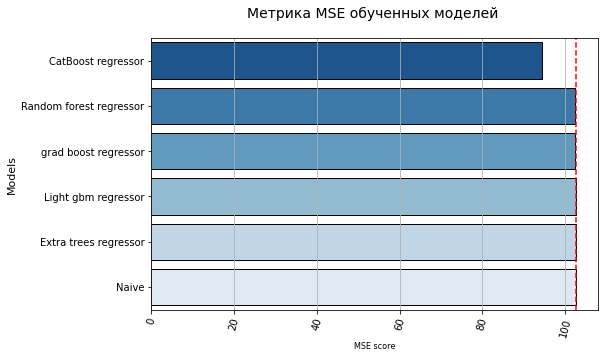

In [403]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.xticks(rotation=75)
plt.title('Метрика MSE обученных моделей ',fontsize=14, pad=20)

sns.barplot(data=evaluation, x='mse test', y='model', dodge='True',capsize= 0.000001,
                       palette='Blues_r',linewidth=1,edgecolor=".001")
plt.axvline(102.704,color='r',linestyle = '--')
plt.xlabel('MSE score', fontsize=8, )
plt.ylabel('Models', fontsize=11)
plt.show()

Целью задачи 1 было предсказание, когда семья разместит заказ

Эта задача была сведена к задаче регрессии. Использовались основные алгоритмы регрессии. Лучший результат показал catboost regressor. 
Нужно отметить, что во всех алгоритмах видно ухудшение результатов на тестовой выборке по сравнению с валидационной. Это связано с хрогологическим разделением данных. А как мы заметили в EDA поведение семей в 2022 сильно изменилось, увеличились сами заказы, сроки реализации. Я искал модель, которая покажет себя наилучшим образом на тестовой выборке, а также будет адаптироваться к изменяющимся условиям, связанным с увеличением сроков.